In [3]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict
from sklearn.linear_model import LogisticRegression, Lasso
import seaborn as sns
import numpy as np
import utils
from Model import Model
import matplotlib.pyplot as plt
from tqdm import tqdm
from PrecisionMatrixBuilder import PrecisionMatrixBuilder
from Forecaster import Forecaster
from MyDataLoader import MyDataLoader
from PortfolioConstructor import PortfolioConstructor
from BackTester import BackTester
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, GroupNormalizer, Baseline
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, RMSE
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import torch
import pytorch_lightning as pl
from networks import LinearRegression, MLP, LSTM

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

Stellantis and WLN have a lot of missing prices compared to the other stocks in the CAC40: we exclude them from this analysis.

In [38]:
dataloader = MyDataLoader()

In [39]:
fd = dataloader.load_full_dataset()

[*********************100%***********************]  39 of 39 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [35]:
full_dataset, stock_names, time_index = dataloader.load_full_dataset_array()

In [3]:
column_names = dataloader.load_feature_names()

In [4]:
tscv = list(utils.time_series_cross_validation(full_dataset, time_index, n_splits=10, valid_size=66, test_size=66))

LSTM example:

In [5]:
train, train_index, valid, valid_index, test, test_index = tscv[0]
stock = 0
X_train, y_train = train[:, stock, 2:], train[:, stock, 1]
X_valid, y_valid = valid[:, stock, 2:], valid[:, stock, 1]
X_test, y_test = test[:, stock, 2:], test[:, stock, 1]
X_full = np.vstack([X_train, X_valid, X_test])
y_full = np.hstack([y_train, y_valid, y_test])
X_train, y_train, X_valid, y_valid, X_test, y_test = utils.load_data_for_rnn(X_full, y_full, len(train_index), len(valid_index), len(test_index), 60)

In [6]:
from MyDataset import MyDataset
ds = MyDataset(X_train, y_train)
from torch.utils.data import DataLoader
dl = DataLoader(ds, batch_size = 32, shuffle = False)
from networks import LinearRegression, MLP, LSTM

In [53]:
lstm = LSTM(14, 60, 1, "classification")
lstm.fit(dl, dl)
lstm.predict(dl)

In [13]:
config = utils.load_config()
alphas = config["alphas"]
thetas = config["thetas"]
lambdas = config["lambdas"]
capital = config["capital"]

In [14]:
returns = dataloader.load_returns()

In [1]:
import os

In [7]:
precision_matrix_builder = PrecisionMatrixBuilder(returns = returns, window = 512, alphas = alphas, thetas = thetas)
# prec_mat = precision_matrix_builder.get_precision_matrix()

In [6]:
import pickle
with open("precision_mat.pkl", "rb") as f:
    prec_mat = pickle.load(f)

In [7]:
benchmark_returns = dataloader.load_benchmark(date_index=time_index)
risk_free = dataloader.load_risk_free_rate(time_index)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [15]:
from Forecaster import Forecaster
forecaster = Forecaster(full_dataset, stock_names, time_index, valid_size=66, test_size=66, n_splits=10)

In [32]:
model_1 = Model("Lasso", "regression", Lasso(0.05))
model_2 = Model("LogisticRegression", "classification", LogisticRegression(C = 0.2, penalty="l1", solver="saga"))
model_3 = Model("LinearRegression", "regression", LinearRegression(14))
model_4 = Model(name = "MultiLayerPerceptronRegression", type = "regression", model_class= MLP(14, 64, 3, model_type="regression"))
model_5 = Model(name = "MultiLayerPerceptronClassification", type = "classification", model_class= MLP(14, 64, 3, model_type="classification"))

In [16]:
model_6 = Model("LSTMClassifcation", "classification", LSTM(14, 60, 1, "classification"), is_rnn=True)
model_7 = Model("LSTMRegression", "regression", LSTM(14, 60, 1, "regression"), is_rnn=True)
models = [model_6, model_7]

In [21]:
forecasts_val, forecasts_test, weights_valid, weights_test, opt_param_dict, valid_index_full, test_index_full = forecaster.evaluate_test_models(models = models, prec_mat = prec_mat, lambdas = lambdas, alphas = alphas, thetas = thetas, capital = capital, stock_returns=returns, risk_free=risk_free, benchmark_returns=benchmark_returns)

100%|██████████| 2/2 [53:51<00:00, 1615.65s/it]
10it [8:19:25, 2996.53s/it]


Text(0, 0.5, 'Missclassification rate')

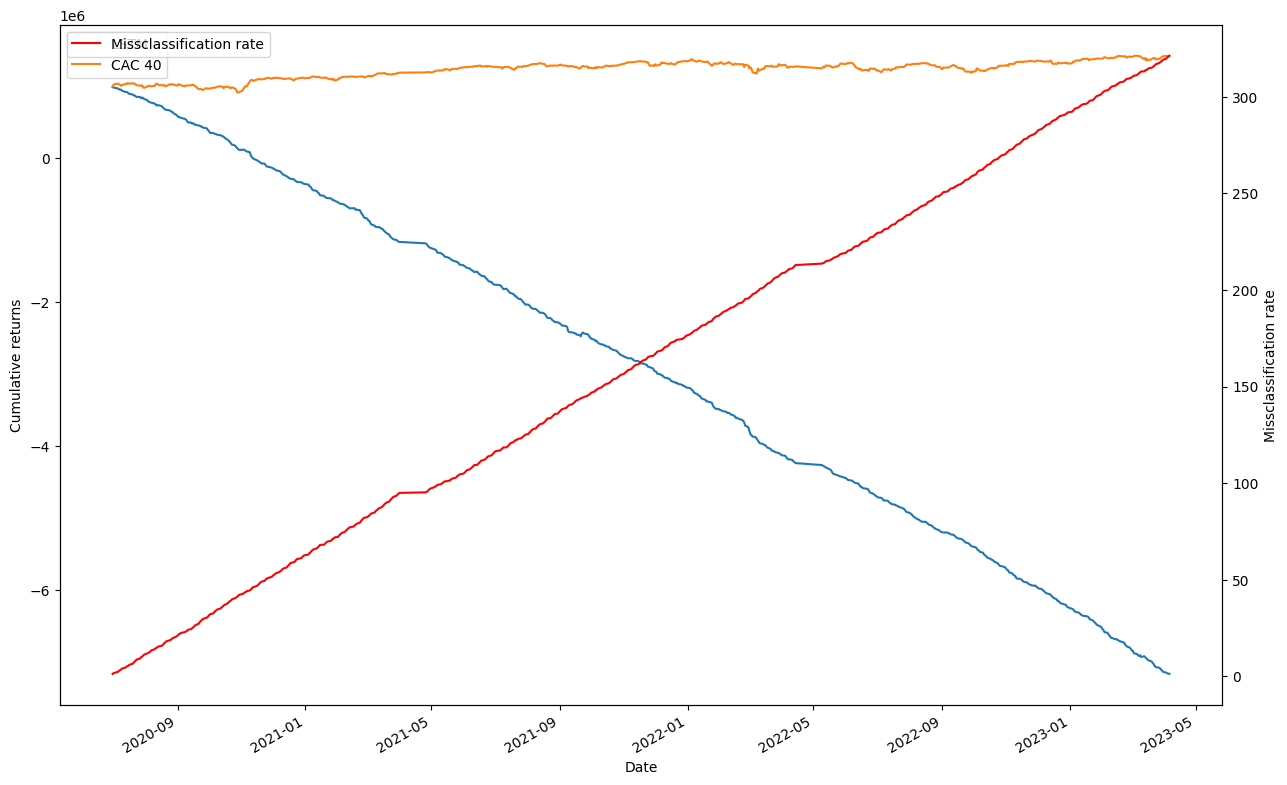

In [26]:
backtest = BackTester(weights_test["LSTMClassifcation"], returns, capital, risk_free, benchmark=benchmark_returns, name = "LSTM")
backtest_statistics = backtest.get_backtest_statistics()
cum_returns = backtest.get_strategy_cumulative_returns()
cum_returns["Missclassification rate"] = (2*forecasts_test["LSTMClassifcation"]-1 != np.sign(returns.loc[test_index_full, :])).abs().mean(axis = 1).cumsum()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
cum_returns.plot(y = ["LSTM", "CAC 40"], ax = ax1, figsize = (15, 10))
cum_returns.plot(y = "Missclassification rate", ax = ax2, color = "red")
ax1.set_ylabel("Cumulative returns")
ax2.set_ylabel("Missclassification rate")

In [27]:
backtest_statistics

Yearly excess returns         -3.121837
Yearly standard deviation      0.131362
Max DD                       585.825317
Yearly Sharpe                -23.765137
Yearly Calmar                 -0.005329
Yearly Sortino               -26.327706
Daily Turnover                 1.553490
dtype: float64

Text(0, 0.5, 'MSE')

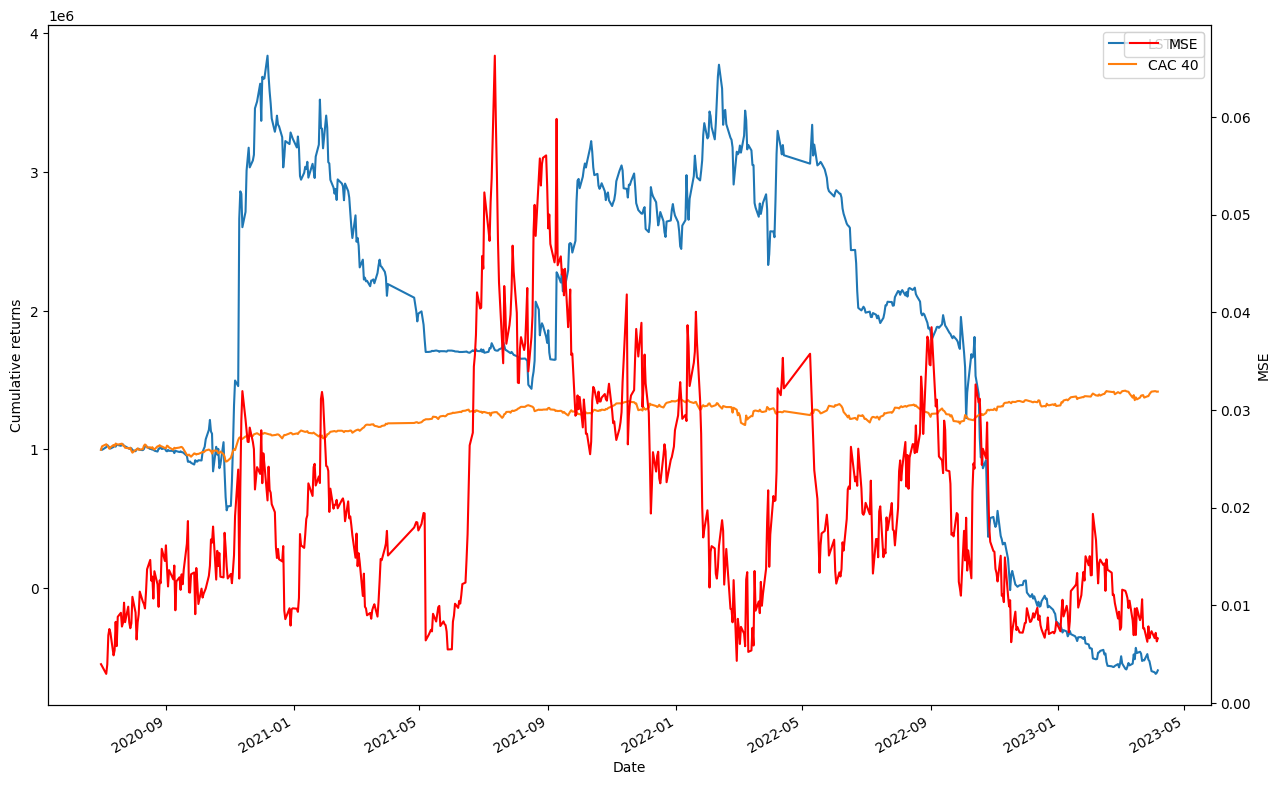

In [28]:
backtest = BackTester(weights_test["LSTMRegression"], returns, capital, risk_free, benchmark=benchmark_returns, name = "LSTM")
backtest_statistics = backtest.get_backtest_statistics()
cum_returns = backtest.get_strategy_cumulative_returns()
cum_returns["MSE"] = (forecasts_test["LSTMRegression"] - returns.loc[test_index_full, :]).apply(lambda x: x**2).mean(axis = 1)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
cum_returns.plot(y = ["LSTM", "CAC 40"], ax = ax1, figsize = (15, 10))
cum_returns.plot(y = "MSE", ax = ax2, color = "red")
ax1.set_ylabel("Cumulative returns")
ax2.set_ylabel("MSE")

In [29]:
backtest_statistics

Yearly excess returns       -0.608853
Yearly standard deviation    1.676436
Max DD                       3.946242
Yearly Sharpe               -0.363183
Yearly Calmar               -0.154287
Yearly Sortino              -0.572060
Daily Turnover               1.743551
dtype: float64

In [213]:
weights_test_full_lasso = weights_test["Lasso"]
weights_test_full_logistic = weights_test["LogisticRegression"]
weights_test_full_linear = weights_test["LinearRegression"]

In [81]:
weights_test_full_MLP_regression = weights_test["MultiLayerPerceptronRegression"]
weights_test_full_MLP_classification = weights_test["MultiLayerPerceptronClassification"]

Text(0, 0.5, 'MSE')

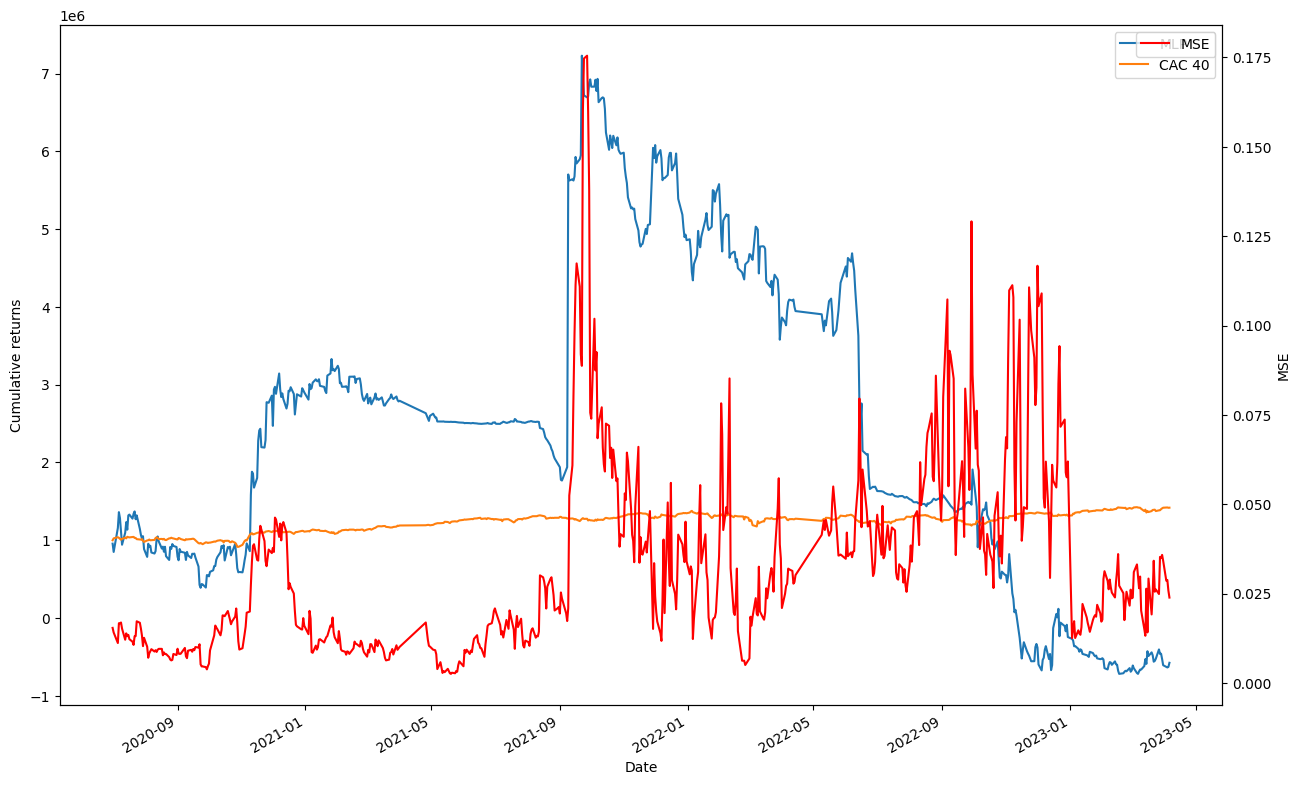

In [89]:
backtest = BackTester(weights_test_full_MLP_regression, returns, capital, risk_free, benchmark=benchmark_returns, name = "MLP")
backtest_statistics = backtest.get_backtest_statistics()
cum_returns = backtest.get_strategy_cumulative_returns()
cum_returns["MSE"] = (forecasts_test["MultiLayerPerceptronRegression"] - returns.loc[test_index_full, :]).apply(lambda x: x**2).mean(axis = 1)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
cum_returns.plot(y = ["MLP", "CAC 40"], ax = ax1, figsize = (15, 10))
cum_returns.plot(y = "MSE", ax = ax2, color = "red")
ax1.set_ylabel("Cumulative returns")
ax2.set_ylabel("MSE")

In [90]:
backtest_statistics

Yearly excess returns       -0.603227
Yearly standard deviation    3.340953
Max DD                       2.658905
Yearly Sharpe               -0.180555
Yearly Calmar               -0.226870
Yearly Sortino              -0.339237
Daily Turnover               3.121668
dtype: float64

Text(0, 0.5, 'Missclassification rate')

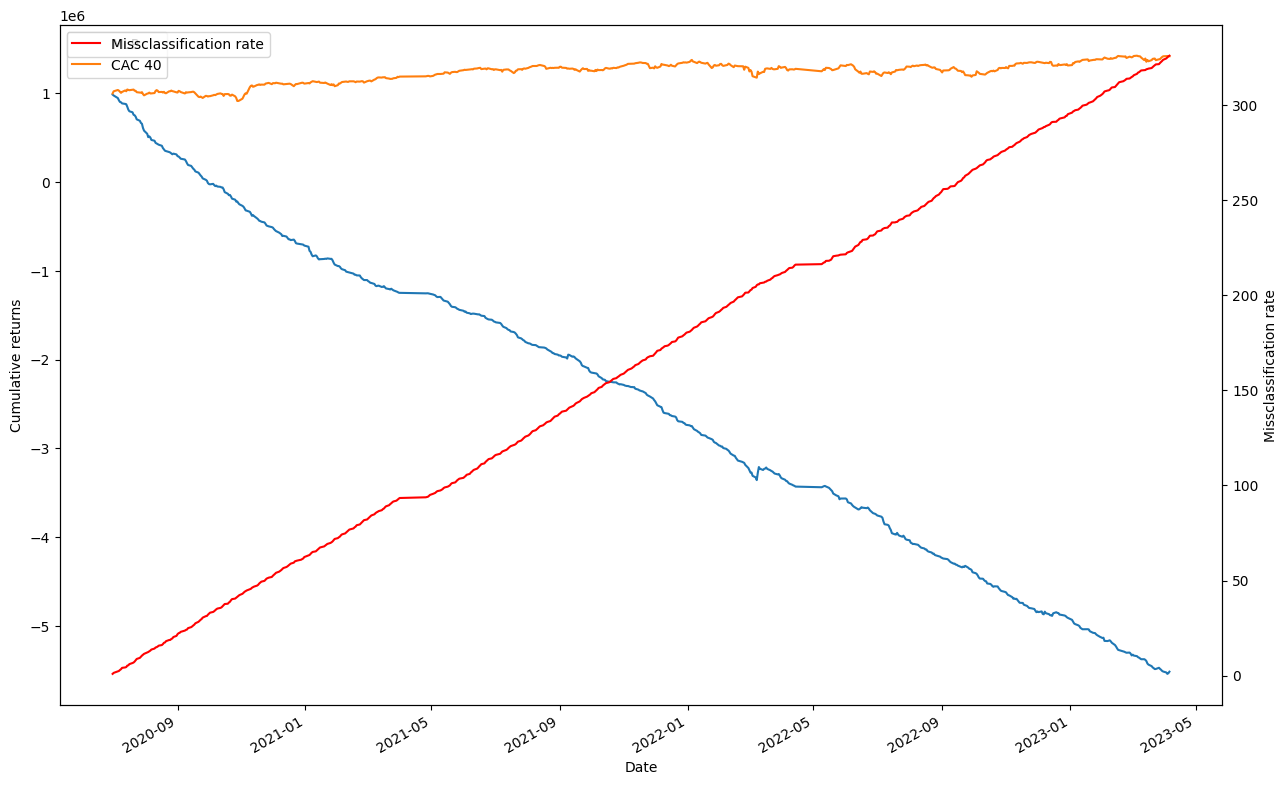

In [91]:
backtest = BackTester(weights_test_full_MLP_classification, returns, capital, risk_free, benchmark=benchmark_returns, name = "MLP")
backtest_statistics = backtest.get_backtest_statistics()
cum_returns = backtest.get_strategy_cumulative_returns()
cum_returns["Missclassification rate"] = ((2*forecasts_test["MultiLayerPerceptronClassification"]-1) != np.sign(returns.loc[test_index_full, :])).abs().mean(axis = 1).cumsum()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
cum_returns.plot(y = ["MLP", "CAC 40"], ax = ax1, figsize = (15, 10))
cum_returns.plot(y = "Missclassification rate", ax = ax2, color = "red")
ax1.set_ylabel("Cumulative returns")
ax2.set_ylabel("Missclassification rate")

In [92]:
backtest_statistics

Yearly excess returns         -2.492288
Yearly standard deviation      0.174404
Max DD                       459.382154
Yearly Sharpe                -14.290347
Yearly Calmar                 -0.005425
Yearly Sortino               -19.314275
Daily Turnover                 1.377301
dtype: float64

In [88]:
((2*forecasts_test["MultiLayerPerceptronClassification"]-1) != np.sign(returns.loc[test_index_full, :])).abs().mean(axis = 1).mean()

0.49397926634768735

Text(0, 0.5, 'MSE')

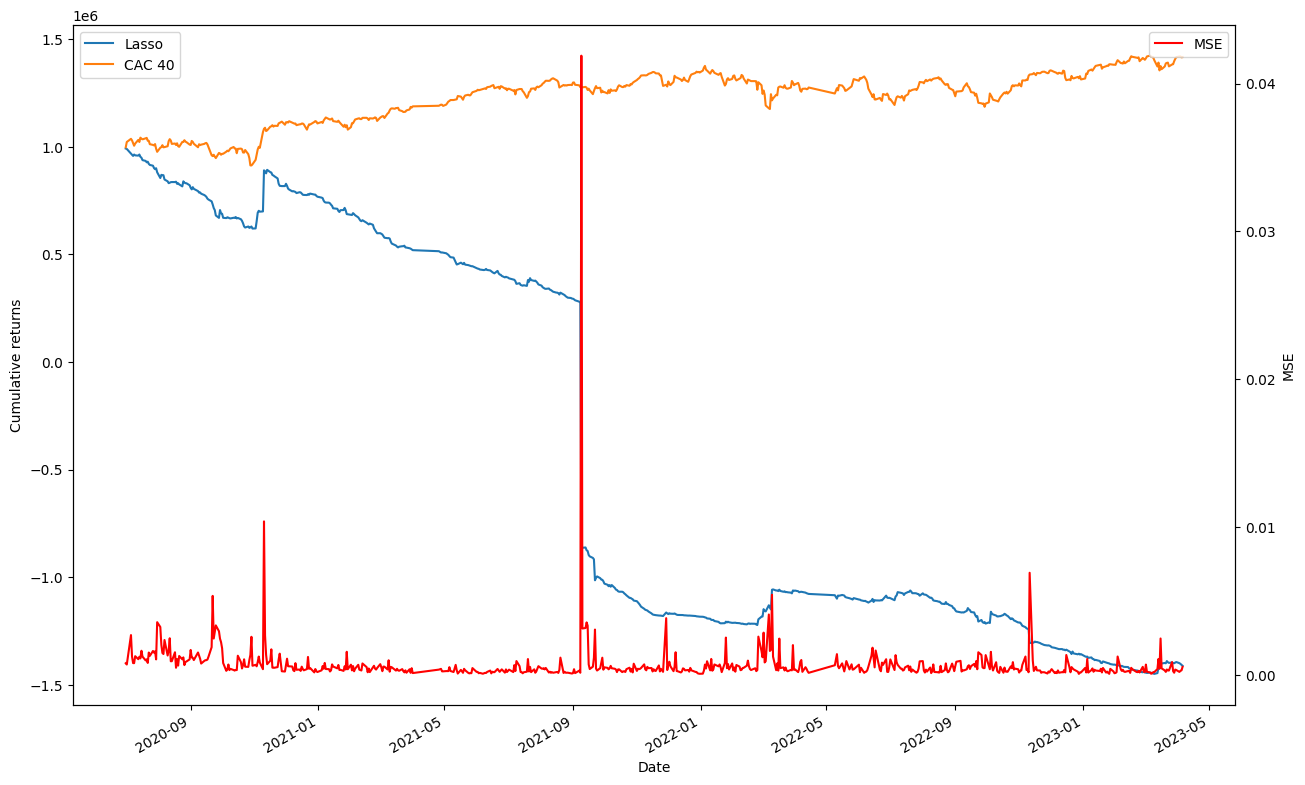

In [209]:
backtest = BackTester(weights_test_full_lasso, returns, capital, risk_free, benchmark=benchmark_returns, name = "Lasso")
backtest_statistics = backtest.get_backtest_statistics()
cum_returns = backtest.get_strategy_cumulative_returns()
cum_returns["MSE"] = (forecasts_test["Lasso"] - returns.loc[test_index_full, :]).apply(lambda x: x**2).mean(axis = 1)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
cum_returns.plot(y = ["Lasso", "CAC 40"], ax = ax1, figsize = (15, 10))
cum_returns.plot(y = "MSE", ax = ax2, color = "red")
ax1.set_ylabel("Cumulative returns")
ax2.set_ylabel("MSE")

In [210]:
cum_returns["MSE"].sum()

0.46259962194397763

In [211]:
backtest_statistics

Yearly excess returns         -0.922446
Yearly standard deviation      0.726578
Max DD                       320.296525
Yearly Sharpe                 -1.269575
Yearly Calmar                 -0.002880
Yearly Sortino                -1.133783
Daily Turnover                 0.568273
dtype: float64

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

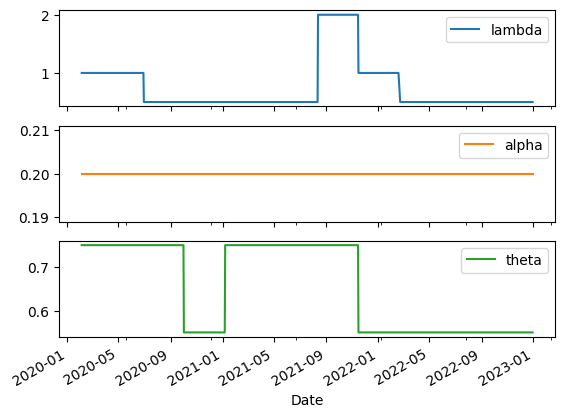

In [212]:
opt_param_dict["Lasso"].plot(subplots = True)

Text(0, 0.5, 'MSE')

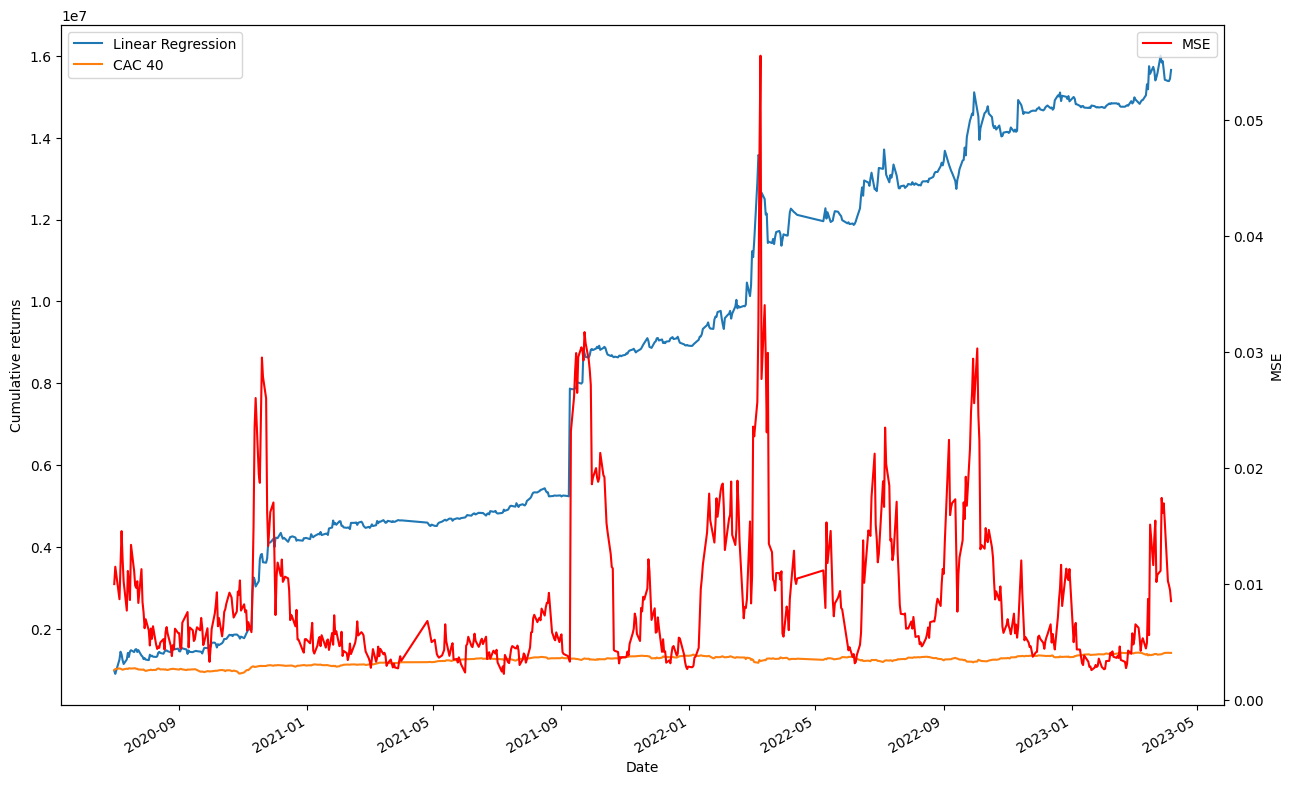

In [216]:
backtest = BackTester(weights_test_full_linear, returns, capital, risk_free, benchmark=benchmark_returns, name = "Linear Regression")
backtest_statistics = backtest.get_backtest_statistics()
cum_returns = backtest.get_strategy_cumulative_returns()
cum_returns["MSE"] = (forecasts_test["LinearRegression"] - returns.loc[test_index_full, :]).apply(lambda x: x**2).mean(axis = 1)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
cum_returns.plot(y = ["Linear Regression", "CAC 40"], ax = ax1, figsize = (15, 10))
cum_returns.plot(y = "MSE", ax = ax2, color = "red")
ax1.set_ylabel("Cumulative returns")
ax2.set_ylabel("MSE")

In [217]:
backtest_statistics

Yearly excess returns        5.603746
Yearly standard deviation    3.038003
Max DD                       4.629712
Yearly Sharpe                1.844550
Yearly Calmar                1.210388
Yearly Sortino               2.794014
Daily Turnover               1.839745
dtype: float64

Text(0, 0.5, 'Misclassification rate')

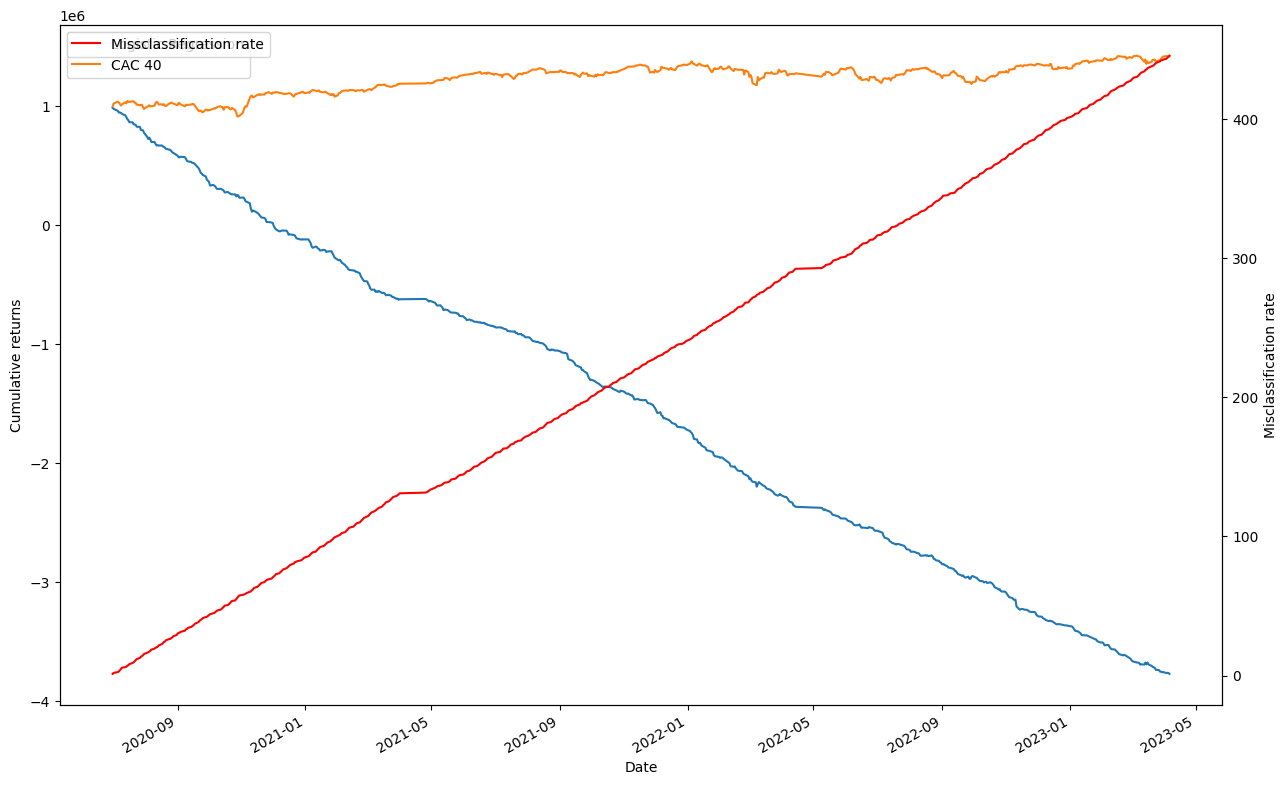

In [218]:
backtest = BackTester(weights_test_full_logistic, returns, capital, risk_free, benchmark = benchmark_returns, name = "Logistic Regression")
backtest_statistics = backtest.get_backtest_statistics()
cum_returns = backtest.get_strategy_cumulative_returns()
cum_returns["Missclassification rate"] = (forecasts_test["LogisticRegression"] != np.sign(returns.loc[test_index_full, :])).abs().mean(axis = 1).cumsum()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
cum_returns.plot(y = ["Logistic Regression", "CAC 40"], ax = ax1, figsize = (15, 10))
cum_returns.plot(y = "Missclassification rate", ax = ax2, color = "red")
ax1.set_ylabel("Cumulative returns")
ax2.set_ylabel("Misclassification rate")

In [219]:
(forecasts_test["LogisticRegression"] != np.sign(returns.loc[test_index_full, :])).abs().mean(axis = 1).mean()

0.6746012759170656

In [220]:
backtest_statistics

Yearly excess returns         -1.823427
Yearly standard deviation      0.133675
Max DD                       345.747608
Yearly Sharpe                -13.640795
Yearly Calmar                 -0.005274
Yearly Sortino               -15.904763
Daily Turnover                 0.757855
dtype: float64